In [1]:
from PIL import Image
import numpy as np

In [2]:
rom=( np.fromfile('rom_upper.bin',dtype=np.uint16).astype(np.uint32)<<16) \
    | np.fromfile('rom_lower.bin',dtype=np.uint16)

In [3]:
def romSequence(rom=rom,start_addr=0,addr_mask=None,max_iter=None):
  if addr_mask==None: addr_mask=(1<<((len(rom)-1).bit_length()))-1
  if max_iter==None:  max_iter=2*len(rom) #ensures full cycle for ramdom start address
  addr=start_addr
  while max_iter!=0: #infinite loop if max_iter <= -1
    data=rom[addr]
    yield data
    addr=data&addr_mask
    max_iter-=1
    if max_iter < -1: max_iter = -1 #prevent negative overflow

In [4]:
def b332toRGB(b332):#red: 3 bits, green: 3 bits, blue: 2 bits
  deltaRG=255/7
  deltaB=255/3
  return (int(((b332>>5)&7)*deltaRG+0.5), \
          int(((b332>>2)&7)*deltaRG+0.5), \
          int((b332&3)*deltaB+0.5))

In [5]:
VideoRAM=np.zeros(640*480,dtype=np.uint8)
VideoRAM[[k^(k>>1)^(480*640//2) for k in range(480*640)]]= \
          np.array(bytearray(Image.open('Starman.png').getdata()),dtype=np.uint8)

In [6]:
frame1=Image.new('RGB',(800,525))
old_hsync=old_vsync=False
x=y=vsync_count=0

for data_output in romSequence(rom):
  if vsync_count>=2: 
    break
  blank=(data_output&(1<<19))!=0
  addr_valid=(data_output&(1<<20))!=0
  hsync=(data_output&(1<<21))!=0
  vsync=(data_output&(1<<22))!=0
  clk=(data_output&(1<<23))!=0
  addr=data_output&((1<<20)-1)#20-bit address
  if old_hsync and not hsync: #detect falling edge of hsync: start of scan line
    x=0
    y+=1
    y=min(y,524)
  else:
    x+=1
    x=min(x,799)
  if old_vsync and not vsync: #detect falling edge of vsync: start of new frame
    vsync_count+=1
    y=0
  if vsync_count>=1:
    if addr_valid:
      pixel=b332toRGB(VideoRAM[addr])#read byte from gray-ordered array, convert to RGB
#      pixel=b332toRGB(data_output>>24)#use bit 24 to 31 as pixel data, convert to RGB
      pass
    else:
      pixel=(255 if hsync else 0,255 if vsync else 0,255 if clk else 0)  
    frame1.putpixel((x,y),pixel)
  old_hsync,old_vsync=hsync,vsync 

Video Data, as sent to Monitor: red=hsync, green=vsync, blue=address parity


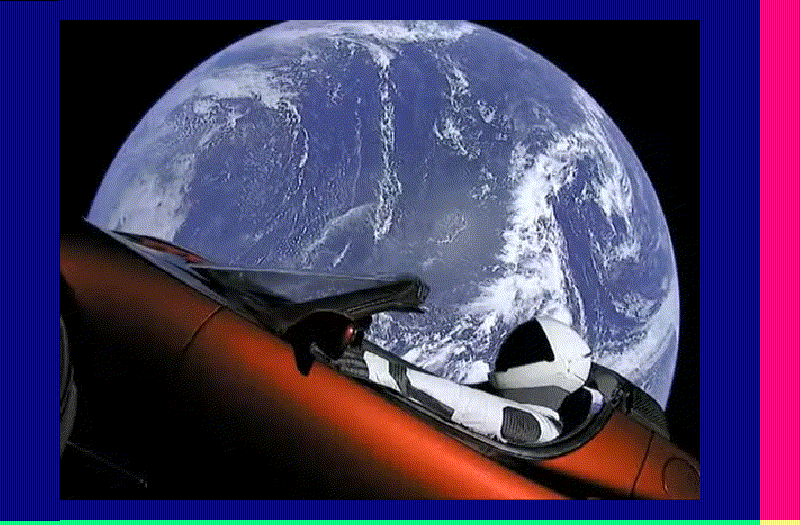

In [11]:
print('Video Data, as sent to Monitor: red=hsync, green=vsync, blue=address parity')
frame1 

Image Data, as stored in Video RAM:


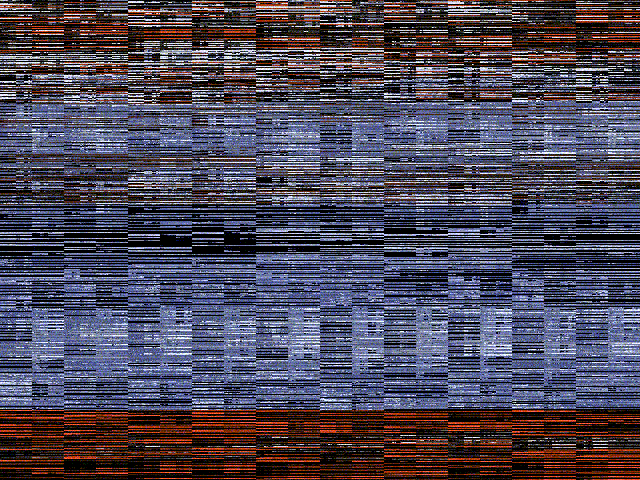

In [15]:
print('Image Data, as stored in Video RAM:')
Image.fromarray(np.array(list(map(b332toRGB, VideoRAM)), dtype=np.uint8).reshape((480,640,3)))